Predicting Survival in the Titanic Data Set
We will be using a decision tree to make predictions about the Titanic data set from
Kaggle. This data set provides information on the Titanic passengers and can be used to
predict whether a passenger survived or not.

In [23]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report


In [24]:
Url='https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(Url)

In [25]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [26]:
titanic.shape

(891, 12)

In [27]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [28]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Some observations. We see that the survival rate is the 38% mentioned earlier. <br>Pclass has 3 integer values (also mentioned in description) <br> It looks like we have some incomplete values for Age (714 non-null values of a total 891) and Cabin (only 204 non-null values)

In [29]:
# use nunique to find the number of unique values for each feature
titanic.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [30]:
titanic.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"O'Brien, Mr. Thomas",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


At this point in the tutorial described above, the "5Cs" are mentioned before proceeding further into the analysis. Correlation, Completing, Correcting, Creating, Classifying.

Correlation Some features will be more correlated with Survival than others. We should determine these, but be careful to revisit in case we are proven wrong later.

Completing We can see above than some of the features contain null values. Age and Embarked as features that should be completed.

Correcting Can we drop any information safely from our analysis? Name is likely not correlated with survival, and all values are unique anyway. Others are Ticket (Ticket Class, information such as First, Second etc), Cabin (Cabin Number, mostly incomplete data) and PassengerID (just a numeric identifier for each passenger).

Creating This is an interesting step- here we take a look at the features we already have and see if we can derive anything more useful. As mentioned in the tutorial. Family -> combine Parch (parent-child) and Sibsp (number of siblings on board). Title --> obtain from Name (as a proxy for socio-economic status perhaps?) Age --> bin values to create an ordinal categorical feature Fare range?

Classifying Women, children and upper-class passengers were more likely to have survived. (Sex= Female, Age <?? Pclass=1 respectively

# Pivot features against Survival
Perform some exploratory analysis of various features against survival to see how well they are correlated. 
The features below are selected as they are complete, categorical/discretely valued.

In [31]:
titanic[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [32]:
titanic[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [33]:
titanic[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [34]:
titanic[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Some patterns are starting to become evident from the pivot tables above - FirstClass passengers are more likely to have survived, as are women. SibSp and Parch need further investigation.

# Data visualization

Investigate a bit further using histograms. Plot the numerical features vs. survival We will use the Seaborn package (FacetGrid)

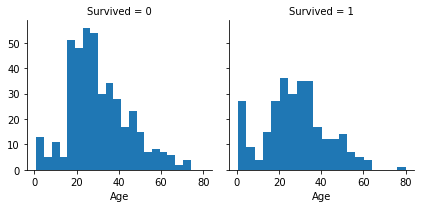

In [35]:
import seaborn as sns

g = sns.FacetGrid(titanic, col='Survived')
g.map(plt.hist, 'Age', bins=20)

# Observations
Young Children had a high survival rate (>20%) <br>
Many 15-25 year olds did not survive.<br>
Majority of passengers are in the 15-35 age range.

# Correlating numerical and ordinal features
Below we will combine multiple features to identify correlations with one plot. We will use numerical and categorical features 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


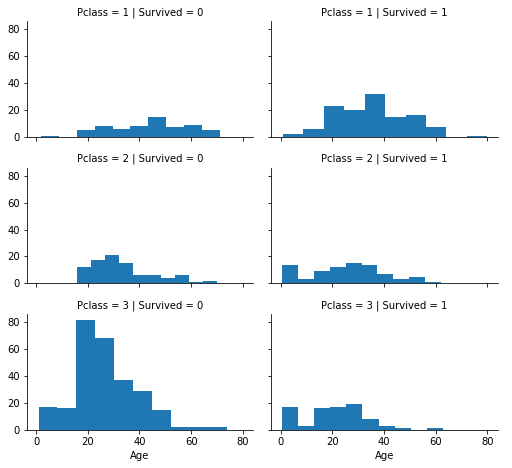

In [36]:
grid = sns.FacetGrid(titanic, col='Survived', row='Pclass', size=2.2, aspect=1.6 )
grid.map(plt.hist, 'Age')
grid.add_legend()

# Observations

Pclass=3 had the most passengers but most of them did not survive.

The youngest passengers (ie less than 5) in Pclass=2 and Pclass=3 mostly survived. 

Most passengers in Pclass=1 survived. Pclass varies in terms of Age distribution of passengers.

Based on these observations, Pclass is good to consider for model training

# Correlating categorical features¶
Let us examine the sex of the passenger, the class and where they embarked with survival. 
We will use line/point plots on the same facetgrid for each embarkation point.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis)

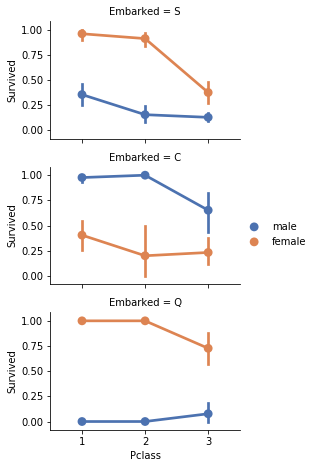

In [37]:
grid = sns.FacetGrid(titanic, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

# Observations

PClass 1 and 2 generally had higher survival rates

Females in 2 of the 3 embarkment points had significantly higher survival rates than males.
A similar pattern is observed for the other embarkment point for males (C)

Point of embarkment does have a varying effect on survival for males.

Based on this, Embarked and Sex will be added to model training. Embarked has 889 non null values so the remaining two will need to be completed.

# Correlating categorical with numerical features
We can now compare some of the categorical features (Embarked, Sex) with the numeric feature Fare 
as it seems that these all had an impact on survival.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


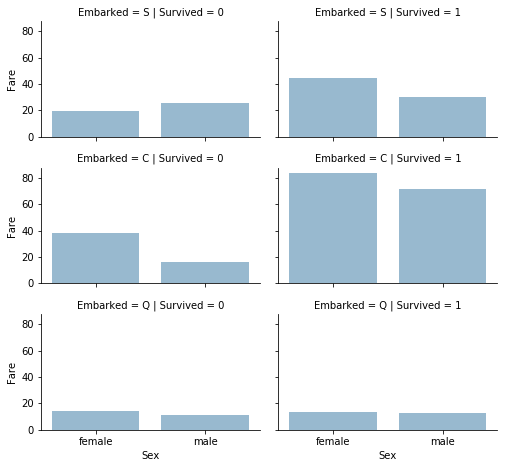

In [38]:
grid = sns.FacetGrid(titanic, row='Embarked', col='Survived',size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=0.5, ci=None)
grid.add_legend()

# Observations
Embarkment point affects survival

Again, in general females have higher survival rate

Higher paying passengers had higher survival rate

# Data wrangling

We now have a better idea of what features have a strong impact on survival and those that don't

In [41]:
# Dropping Cabin and Ticket feature
titanic = titanic.drop(['Ticket', 'Cabin','PassengerId','Name','SibSp','Parch','Fare'], axis=1)

In [42]:
titanic.head()

,Survived,Pclass,Sex,Age,Embarked
0,0,3,male,22.0,S
1,1,1,female,38.0,C
2,1,3,female,26.0,S
3,1,1,female,35.0,S
4,0,3,male,35.0,S


In [45]:
# Replacing Na

titanic['Age'].fillna((titanic['Age'].mean()), inplace=True) # replaced with mean
titanic['Embarked'].fillna('S', inplace=True)  # replaced with top

In [47]:
titanic.describe(include=['O'])

,Sex,Embarked
count,891,891
unique,2,3
top,male,S
freq,577,646


# Convert categorical to numeric

In [48]:
titanic['Embarked'] = titanic['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2}).astype(int)
titanic['Sex'] = titanic['Sex'].map( {'female': 0, 'male': 1}).astype(int)
titanic.head()


,Survived,Pclass,Sex,Age,Embarked
0,0,3,1,22.0,0
1,1,1,0,38.0,1
2,1,3,0,26.0,0
3,1,1,0,35.0,0
4,0,3,1,35.0,0


In [49]:
# Checking if all the null values have been imputed
titanic.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
Embarked    0
dtype: int64

In [50]:
X = titanic.drop("Survived", axis = 1)
Y = titanic.Survived

X.head()

,Pclass,Sex,Age,Embarked
0,3,1,22.0,0
1,1,0,38.0,1
2,3,0,26.0,0
3,1,0,35.0,0
4,3,1,35.0,0


In [51]:
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# Train Test Split

In [52]:
x_train,x_test,y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state =100)

In [57]:
x_test.shape

(179, 4)

In [59]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
Y_pred = decision_tree.predict(x_test)
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

90.45

In [61]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)
Y_pred = random_forest.predict(x_test)
acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)
acc_random_forest

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


90.45

# Model Evaluation

Both decision tree and Random Forest gave the same score, but Random Forest is acknowledged as 
slightly better as decision trees have a tendency to overfit the training data set.